In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [3]:
df = pd.read_csv("2021-tripdata.csv")



In [4]:
df.head()

,ride_id,rideable_type,started_at,ride_length,day_of_week,member_casual
0,6065D9E82EF52770,classic_bike,2021-02-12 17:56:00 UTC,03:57:54,Friday,casual
1,9D314AC5569F2196,classic_bike,2021-02-12 11:00:00 UTC,00:59:53,Friday,casual
2,29163D2EAEE0DCB4,classic_bike,2021-02-19 08:30:00 UTC,01:04:27,Friday,casual
3,8BDD81CD7A789BF2,classic_bike,2021-02-05 12:07:00 UTC,05:27:50,Friday,member
4,39A46C32EFB6890B,classic_bike,2021-02-05 17:05:00 UTC,00:56:06,Friday,member


In [5]:
df.shape

(5644538, 6)

5.6 million rows, only 6 columns

In [6]:
df.dtypes

ride_id          object
rideable_type    object
started_at       object
ride_length      object
day_of_week      object
member_casual    object
dtype: object

We will have to convert these data types.

In [7]:
df.isnull().sum()

ride_id          0
rideable_type    0
started_at       0
ride_length      0
day_of_week      0
member_casual    0
dtype: int64

No missing values

## Data Type Conversion

**Categorical**

In [8]:
df['rideable_type'] = df.rideable_type.astype('category')
df['day_of_week'] = df.day_of_week.astype('category')
df['member_casual'] = df.member_casual.astype('category')

**Date and Time**

In [9]:
# remove 'UTC' from 'started_at' col
df['started_at'] = df.apply(lambda x: x['started_at'].split("U")[0], axis = 1)
# convert to datetime data type
df['started_at'] = pd.to_datetime(df['started_at'], format = '%Y-%m-%d %H:%M:%S')

In [10]:
df['ride_length'] = pd.to_datetime(df['ride_length'], format = '%H:%M:%S').dt.time
# Pandas now interprets it as datetime object

In [11]:
df.dtypes

ride_id                  object
rideable_type          category
started_at       datetime64[ns]
ride_length              object
day_of_week            category
member_casual          category
dtype: object

Perfect. We left ride_id alone because it won't be used in regression or plotting

## Feature Creation

### ride_time - the Response variable

Converting ride length to seconds

In [12]:
   def datetime_to_seconds(time):
    # ARGS
    # time - datetime object
    return(time.hour * 60 * 60 + time.minute * 60 + time.second)
    
    
    
    

In [13]:
df['ride_time'] = df.apply(lambda x: datetime_to_seconds(x['ride_length']), axis = 1)

Remove rides that were immediately cancelled. (0 seconds of ride time)

In [14]:
df = df[df.ride_time != 0]
df.shape

(5644028, 7)

In [15]:
5644538 - 5644028

510

That removed 510 rows

**seconds_since_midnight**

Convert "started_at" column into a numeric variable representing the time of day the ride took place.

**now it can be used in regression**

In [16]:

df["seconds_since_midnight"] = df.apply(lambda x: datetime_to_seconds(x["started_at"]), axis = 1)


### days_since_newyear

Convert "started_at" column into a numeric variable representing the time of year the ride takes place

**Now it can be used in regression**

In [17]:
def datetime_to_days(dt):
    compare_dt = datetime.datetime(dt.year, 1, 1)
    return (dt - compare_dt).days

df['days_since_newyear'] = df.apply(lambda x: datetime_to_days(x['started_at']), axis = 1)
df.head(10)

,ride_id,rideable_type,started_at,ride_length,day_of_week,member_casual,ride_time,seconds_since_midnight,days_since_newyear
0,6065D9E82EF52770,classic_bike,2021-02-12 17:56:00,03:57:54,Friday,casual,14274,64560,42
1,9D314AC5569F2196,classic_bike,2021-02-12 11:00:00,00:59:53,Friday,casual,3593,39600,42
2,29163D2EAEE0DCB4,classic_bike,2021-02-19 08:30:00,01:04:27,Friday,casual,3867,30600,49
3,8BDD81CD7A789BF2,classic_bike,2021-02-05 12:07:00,05:27:50,Friday,member,19670,43620,35
4,39A46C32EFB6890B,classic_bike,2021-02-05 17:05:00,00:56:06,Friday,member,3366,61500,35
5,1759C9D10ABD52F0,classic_bike,2021-02-05 08:41:00,00:40:23,Friday,member,2423,31260,35
6,196038F4EE88CB5A,classic_bike,2021-02-05 19:01:00,18:32:36,Friday,member,66756,68460,35
7,7A3044E324455213,classic_bike,2021-02-19 07:43:00,00:59:49,Friday,member,3589,27780,49
8,A5EF918D544E443E,classic_bike,2021-02-05 17:57:00,00:59:53,Friday,casual,3593,64620,35
9,31FAE55254BEE127,classic_bike,2021-02-12 09:40:00,03:48:16,Friday,casual,13696,34800,42


## Predictor Exploration

**rideable_type**

<AxesSubplot:ylabel='Proportion'>

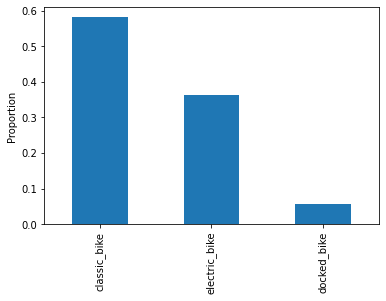

In [18]:
df['rideable_type'].value_counts(normalize = True).plot(kind='bar', ylabel = "Proportion")

**day_of_week**

<AxesSubplot:ylabel='Proportion'>

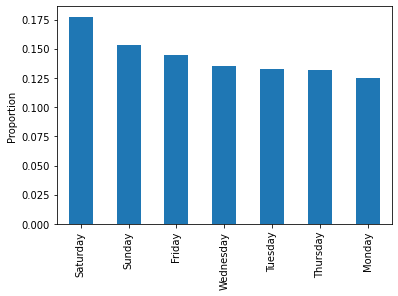

In [19]:
df['day_of_week'].value_counts(normalize = True).plot(kind='bar', ylabel = "Proportion")

**member_casual**

<AxesSubplot:ylabel='Proportion'>

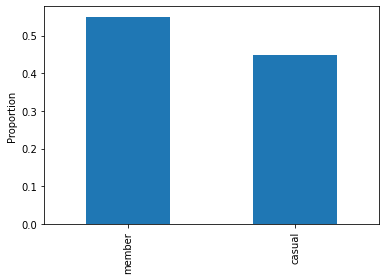

In [20]:
df['member_casual'].value_counts(normalize = True).plot(kind='bar', ylabel = "Proportion")

**started_at**

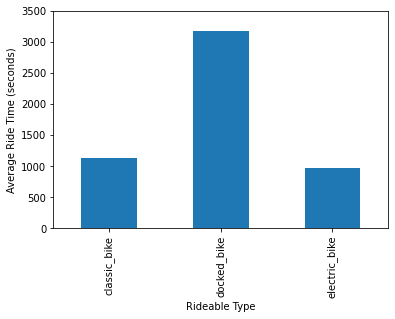

In [21]:
df_seasonal_trends = df.groupby("rideable_type")["ride_time"].mean().plot(
    ylabel = "Average Ride Time (seconds)", 
    xlabel = "Rideable Type",
    kind = "bar",
    ylim = (0, 3500))

<AxesSubplot:xlabel='Hour Ride Started', ylabel='Count'>

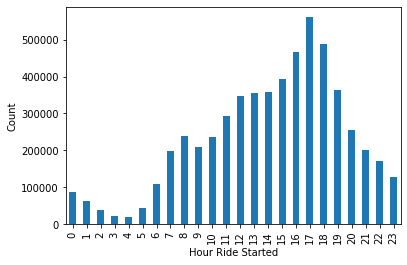

In [22]:
df.groupby(df["started_at"].dt.hour)['started_at'].count().plot(kind="bar", xlabel = "Hour Ride Started", ylabel = "Count")

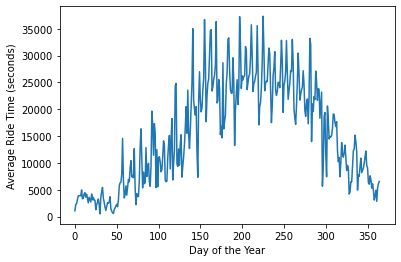

In [41]:
## Trying to convert the plot from below into something that histograms the days since newyear

df_seasonal_trends = df.groupby("days_since_newyear")["days_since_newyear"].count().plot(
    ylabel = "Average Ride Time (seconds)", 
    xlabel = "Day of the Year")

**Correlation and Covariance**

The predictors are not collinear enough to warrant action.

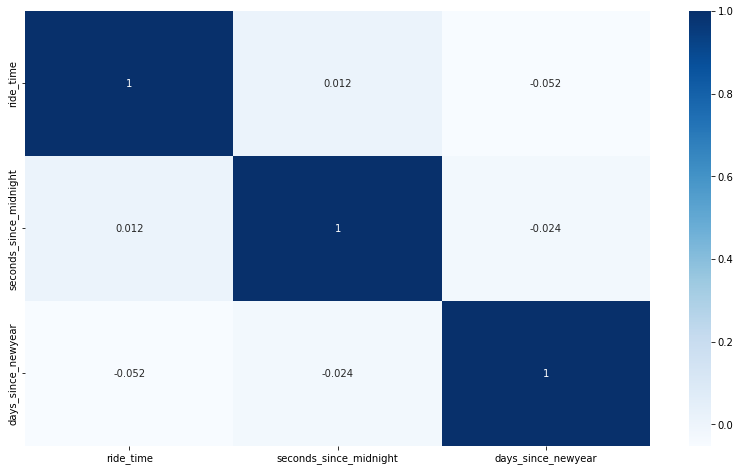

In [24]:
plt.figure(figsize=(14,8))
corr = df.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues")

## Response Variable Exploration

**Ride Time**

Due to how ugly these histograms turned out. I estimated the distribution using a Kernel Density Estimate (KDE) performed in C.

array([[<AxesSubplot:title={'center':'ride_time'}>]], dtype=object)

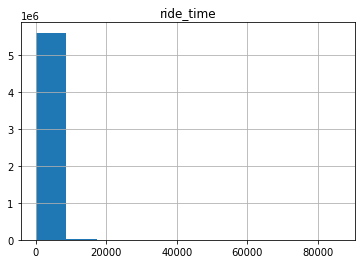

In [25]:
df.hist(column='ride_time')

This histogram is too strongly right skewed to view correctly. I will cut off the top 5% of ride time to better visualize the distribution

In [26]:
cutoff = np.quantile(df['ride_time'], 0.95)

In [27]:
rt_hist_df = df[df.ride_time < cutoff]

array([[<AxesSubplot:title={'center':'ride_time'}>]], dtype=object)

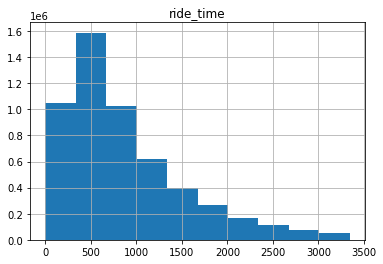

In [28]:
rt_hist_df.hist(column = 'ride_time')

## Response VS Predictor Exploration

Now instead of histogramming the predictors, we explore their relationship with the response variable.

**days_since_newyear** and **seconds_since_midnight**

To make the plots readable we will be converting these two predictors back into datetime objects. We don't use the original axes because we only need the day for the first plot, and we only need the time for the second plot.

In [29]:
df["start_day"] = df.apply(lambda x: x["started_at"].date(), axis = 1)



In [30]:
df["start_time"] = df.apply(lambda x: x["started_at"].time(), axis = 1)

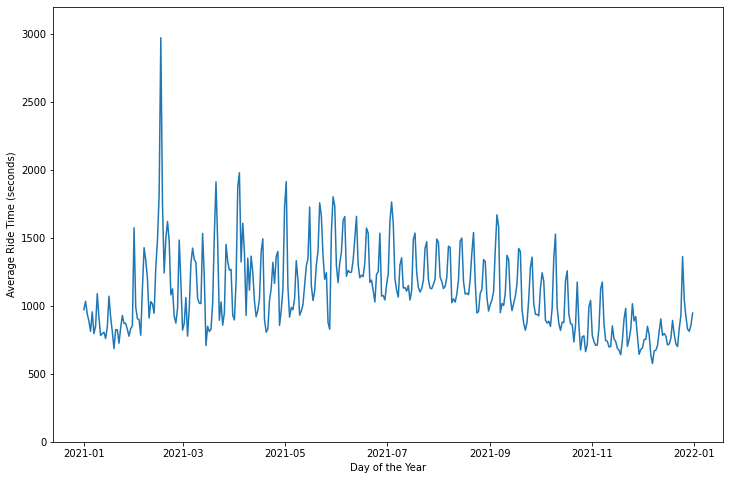

In [31]:
df_seasonal_trends = df.groupby("start_day")["ride_time"].mean().plot(
    ylabel = "Average Ride Time (seconds)", 
    xlabel = "Day of the Year",
    ylim = (0, 3200),
    figsize = (12,8))

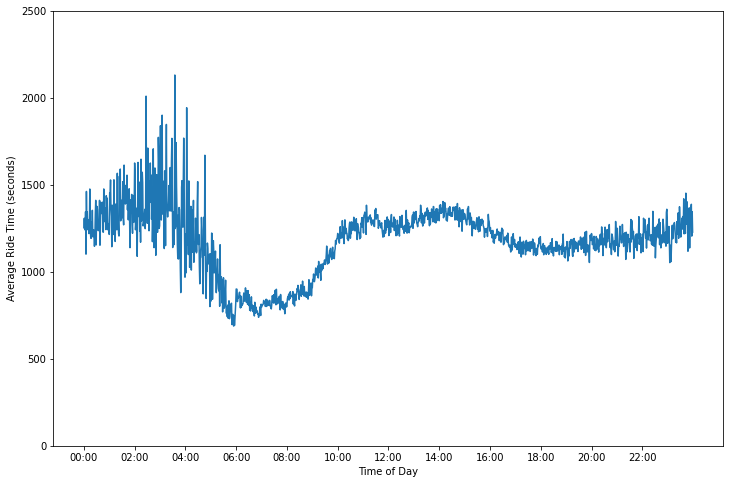

In [32]:
x_ticks_daily = pd.date_range("2020-01-01", "2020-01-02", freq = "2H").format('%H:%M:%S')[1:-1]

df_daily_trends = df.groupby("start_time")["ride_time"].mean().plot(
    ylabel = "Average Ride Time (seconds)", 
    xlabel = "Time of Day",
    xticks = x_ticks_daily,
    ylim = (0, 2500),
    figsize = (12,8))

**member_casual**

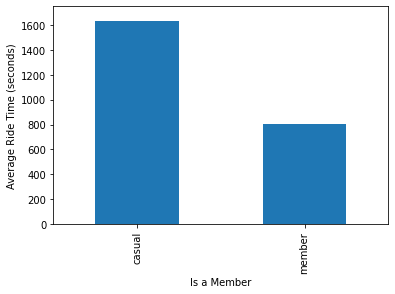

In [33]:
df_seasonal_trends = df.groupby("member_casual")["ride_time"].mean().plot(
    ylabel = "Average Ride Time (seconds)", 
    xlabel = "Is a Member",
    kind = "bar",
    ylim = (0,1750))

**day_of_week**

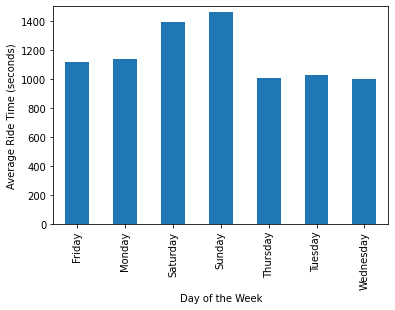

In [34]:
df_seasonal_trends = df.groupby("day_of_week")["ride_time"].mean().plot(
    ylabel = "Average Ride Time (seconds)", 
    xlabel = "Day of the Week",
    kind = "bar",
    ylim = (0, 1500))

**rideable_type**

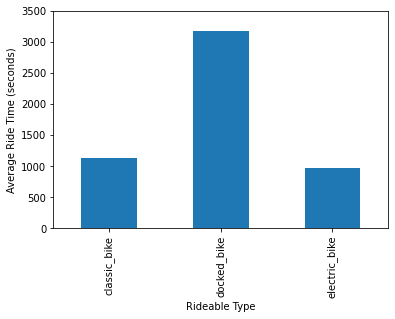

In [35]:
df_seasonal_trends = df.groupby("rideable_type")["ride_time"].mean().plot(
    ylabel = "Average Ride Time (seconds)", 
    xlabel = "Rideable Type",
    kind = "bar",
    ylim = (0, 3500))

### Binary Label Encoding



In [42]:
encoding = {
             "member_casual":
                 {"member": True,
                 "casual": False}
            }
df = df.replace(encoding)
df.head()

,ride_id,rideable_type,started_at,ride_length,day_of_week,member_casual,ride_time,seconds_since_midnight,days_since_newyear,start_day,start_time
0,6065D9E82EF52770,classic_bike,2021-02-12 17:56:00,03:57:54,Friday,False,14274,64560,42,2021-02-12,17:56:00
1,9D314AC5569F2196,classic_bike,2021-02-12 11:00:00,00:59:53,Friday,False,3593,39600,42,2021-02-12,11:00:00
2,29163D2EAEE0DCB4,classic_bike,2021-02-19 08:30:00,01:04:27,Friday,False,3867,30600,49,2021-02-19,08:30:00
3,8BDD81CD7A789BF2,classic_bike,2021-02-05 12:07:00,05:27:50,Friday,True,19670,43620,35,2021-02-05,12:07:00
4,39A46C32EFB6890B,classic_bike,2021-02-05 17:05:00,00:56:06,Friday,True,3366,61500,35,2021-02-05,17:05:00


Remove the unnecessary columns before saving to pickle. This DF will only be used for regression

In [37]:
df_pickle = df.drop(['started_at','ride_length', "start_day", "start_time"], axis=1)

In [38]:
df_pickle.head(10)

,ride_id,rideable_type,day_of_week,member_casual,ride_time,seconds_since_midnight,days_since_newyear
0,6065D9E82EF52770,classic_bike,Friday,False,14274,64560,42
1,9D314AC5569F2196,classic_bike,Friday,False,3593,39600,42
2,29163D2EAEE0DCB4,classic_bike,Friday,False,3867,30600,49
3,8BDD81CD7A789BF2,classic_bike,Friday,True,19670,43620,35
4,39A46C32EFB6890B,classic_bike,Friday,True,3366,61500,35
5,1759C9D10ABD52F0,classic_bike,Friday,True,2423,31260,35
6,196038F4EE88CB5A,classic_bike,Friday,True,66756,68460,35
7,7A3044E324455213,classic_bike,Friday,True,3589,27780,49
8,A5EF918D544E443E,classic_bike,Friday,False,3593,64620,35
9,31FAE55254BEE127,classic_bike,Friday,False,13696,34800,42


In [39]:
df_pickle.dtypes

ride_id                     object
rideable_type             category
day_of_week               category
member_casual                 bool
ride_time                    int64
seconds_since_midnight       int64
days_since_newyear           int64
dtype: object

All of these datatypes are what we wanted.

## Saving Dataframe

Now we will save the dataframe as a pickle for regression. *This way the data types will come pre-loaded*.

In [40]:
df_pickle.to_pickle("2021-tripdata.pkl")